## Лабораторная работа №4

### Задание на лабараторную работу

Найти наиболее информативные признаки для данных вашего варианта. Произвести оценки зависимости точности модели и числа выбранных признаков.

### Результаты, которые необходимо получить в итоге:

1. DataFrame с признаками и их информативностью, отсортированный по убыванию.
2. Графики, показывающие результат оценки зависимости точности модели и числа выбранных признаков.
3. Таблица содержащая f1-score, precision, и recall полученные для лучшей модели, которую вы смогли обучить.
4. Визуализируйте предсказания вашей лучшей модели.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data = np.load('salinas.npy')
mask = np.load('salinas_mask.npy')

In [3]:
data.shape, mask.shape

((512, 217, 224), (512, 217))

In [4]:
ordered_positions = np.array(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))).T.reshape(-1, 2)
train_indices, test_indices = train_test_split(ordered_positions, train_size=0.25, shuffle=True, random_state=1)

In [5]:
X_train, X_test, y_train, y_test = [], [], [], []

for idx in train_indices:
    X_train.append(data[idx[0], idx[1], ::])
    y_train.append(mask[idx[0], idx[1]]) 
    
for idx in test_indices:
    X_test.append(data[idx[0], idx[1], ::])
    y_test.append(mask[idx[0], idx[1]])   
    
X_train = np.array(X_train, copy=False)
y_train = np.array(y_train, copy=False)
X_test = np.array(X_test, copy=False)
y_test = np.array(y_test, copy=False)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27776, 224), (27776,), (83328, 224), (83328,))

In [8]:
X = pd.DataFrame(np.vstack((X_train, X_test)))
Y = pd.DataFrame(np.hstack((y_train, y_test)))

In [9]:
X.shape, Y.shape

((111104, 224), (111104, 1))

In [10]:
number_of_features = X_train.shape[1]

In [11]:
best_features = SelectKBest(score_func=chi2, k=30)

In [12]:
fit = best_features.fit(X_train, y_train)

In [13]:
best_features = pd.DataFrame(data={"feature": range(number_of_features), "chi2_score": fit.scores_}, index=None)

In [14]:
best_features = best_features.sort_values(by="chi2_score", ascending=False)
best_features[:10]

,feature,chi2_score
43,43,1576.892717
44,44,1565.468829
45,45,1544.380235
42,42,1536.501419
46,46,1507.444565
47,47,1494.553716
41,41,1493.176030
48,48,1471.086797
49,49,1425.021739
50,50,1415.728593


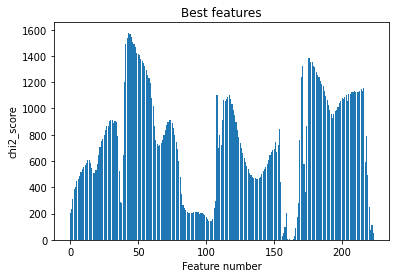

In [15]:
plt.bar(best_features["feature"], best_features["chi2_score"])
plt.title("Best features")
plt.xlabel("Feature number")
plt.ylabel("chi2_score")
plt.show()

In [16]:
scores = []

for i in tqdm(range(10, 31)):
    MLPC = MLPClassifier(max_iter=350)
    features = best_features["feature"].iloc[:i].to_numpy()
    MLPC.fit(X_train[:, features], y_train)
    score = MLPC.score(X_test[:, features], y_test)
    scores.append([i, score])

  0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
numbers_features, accuracy = [], []
best_accuracy, best_number, best_index = 0, 0, 0

for i in tqdm(range(len(scores))):
    numbers_features.append(scores[i][0])
    accuracy.append(scores[i][1])
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_number = numbers_features[-1]
        best_index = i

  0%|          | 0/21 [00:00<?, ?it/s]

In [18]:
print(f"Оптимальное количество признаков среди топ-30: {best_number}")
print(f"Достигнутая точность призаданом количестве: {best_accuracy}")

Оптимальное количество признаков среди топ-30: 25
Достигнутая точность призаданом количестве: 0.7455237135176651


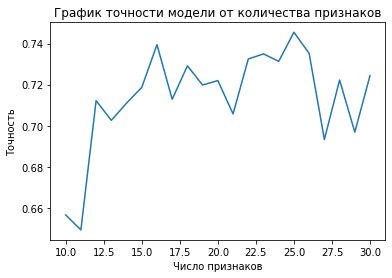

In [19]:
plt.plot(numbers_features, accuracy)
plt.title("График точности модели от количества признаков")
plt.xlabel("Число признаков")
plt.ylabel("Точность")
plt.show()

In [20]:
MLPC = MLPClassifier(max_iter=666)
features = best_features["feature"].iloc[:best_number].to_numpy()
MLPC.fit(X_train[:, features], y_train)
train_pred = MLPC.predict(X_train[:, features])
test_pred = MLPC.predict(X_test[:, features])

In [22]:
print(classification_report(train_pred, y_train))
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     13808
           1       0.99      0.78      0.87       664
           2       0.89      0.86      0.88       970
           3       0.28      0.54      0.37       263
           4       0.83      0.92      0.87       326
           5       0.94      0.76      0.84       828
           6       0.97      0.86      0.91      1115
           7       0.99      0.89      0.93      1031
           8       0.83      0.66      0.74      3420
           9       0.75      0.71      0.73      1656
          10       0.76      0.82      0.79       735
          11       0.75      0.81      0.78       237
          12       0.42      0.55      0.48       351
          13       0.83      0.77      0.80       253
          14       0.81      0.67      0.73       322
          15       0.48      0.66      0.56      1320
          16       0.87      0.76      0.81       477

    accuracy              

In [29]:
predictions_map = np.zeros_like(mask)

for (y, x), pred in zip(train_indices, train_pred):
    predictions_map[y, x] = pred
    
for (y, x), pred in zip(test_indices, test_pred):
    predictions_map[y, x] = pred

Text(0.5, 1.0, 'Predictions')

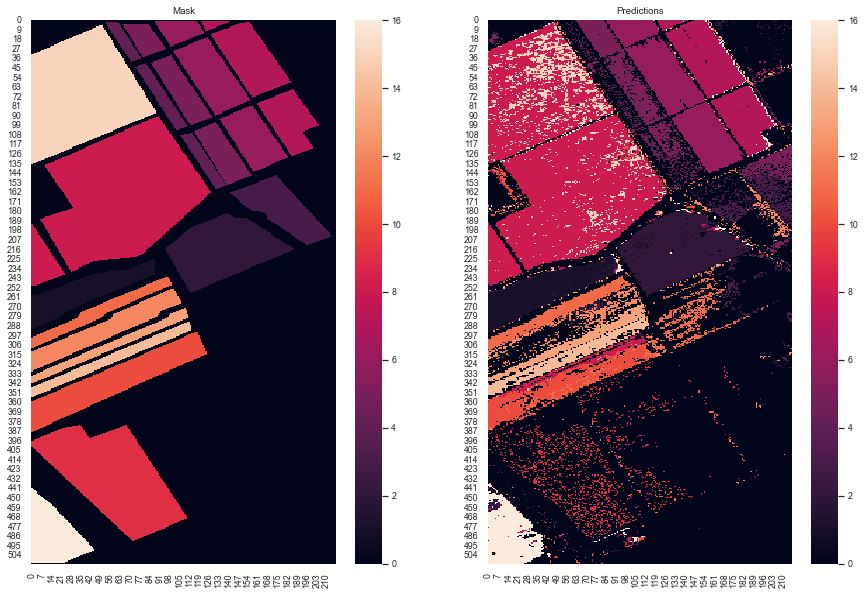

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(predictions_map, ax=ax2)
ax1.set_title("Mask")
ax2.set_title("Predictions")